In [28]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt

from collections import Counter

num_points = 20
critical_radius = 2
d_max = 1.5
rho_threshold = 0.1
distance_threshold = 1.0

num_qubits = int(np.ceil(np.log2(num_points)))
dev = qml.device("default.qubit", wires=num_qubits)

# Generate sample 3D points
np.random.seed(42)
points = np.random.rand(num_points, 3)
points += 0.05 * np.random.randn(*points.shape)
dist_matrix = np.linalg.norm(points[:, None, :] - points[None, :, :], axis=2)


In [29]:
def distance_oracle(index, dist_matrix, radius):
    return [i for i in range(num_points) if i != index and dist_matrix[index, i] < radius]

def apply_oracle(marked_indices):
    for idx in marked_indices:
        bits = list(np.binary_repr(idx, width=num_qubits))
        
        for i, b in enumerate(bits):
            if b == "0":
                qml.PauliX(wires=i)
        
        qml.ctrl(qml.PauliZ, control=list(range(num_qubits - 1)))(wires=num_qubits - 1)
        
        for i, b in enumerate(bits):
            if b == "0":
                qml.PauliX(wires=i)

def diffusion_operator():
    for wire in range(num_qubits):
        qml.Hadamard(wires=wire)
        qml.PauliX(wires=wire)

    qml.Hadamard(wires=num_qubits - 1)
    qml.MultiControlledX(
        wires=list(range(num_qubits - 1)) + [num_qubits - 1],
        control_values=[1] * (num_qubits - 1)
    )
    qml.Hadamard(wires=num_qubits - 1)

    for wire in range(num_qubits):
        qml.PauliX(wires=wire)
        qml.Hadamard(wires=wire)


def grover_iterations(marked_indices, num_iter=1):
    @qml.qnode(dev)
    def circuit():
        for wire in range(num_qubits):
            qml.Hadamard(wires=wire)

        for _ in range(num_iter):
            apply_oracle(marked_indices)
            diffusion_operator()

        return qml.probs(wires=range(num_qubits))

    return circuit()


In [30]:
def compute_local_densities(dist_matrix, critical_radius):
    densities = []
    for index in range(num_points):
        marked = distance_oracle(index, dist_matrix, critical_radius)
        if marked:
            num_iter = max(1, int(np.floor(np.pi / 4 * np.sqrt(len(marked)))))
            probs = grover_iterations(marked, num_iter)
            density = 0.5 * sum(probs[i] for i in marked)
            density += probs[index]
        else:
            density = 0.0
        densities.append(density)
    return np.array(densities)

In [31]:
def find_nearest_higher(index, densities, dist_matrix, d_max):
    rho_j = densities[index]
    dL = 0.0
    dT = d_max
    best_i = -1
    best_d = d_max

    for _ in range(num_qubits):
        marked = [i for i in range(num_points)
                  if i != index and dL < dist_matrix[index, i] < dT and densities[i] > rho_j]

        if not marked:
            dL = dT
            dT = (dT + best_d) / 2
            continue

        num_iter = max(1, int(np.floor(np.pi / 4 * np.sqrt(len(marked)))))
        probs = grover_iterations(marked, num_iter)
        scores = [probs[i] for i in marked]
        i_star = marked[np.argmax(scores)]

        best_i = i_star
        best_d = dist_matrix[index, best_i]
        dT = (dL + best_d) / 2

    return best_i if best_i != -1 else index


def compute_all_nearest_highers(densities, dist_matrix, d_max):
    return np.array([find_nearest_higher(i, densities, dist_matrix, d_max)
                     for i in range(num_points)])

In [32]:
def assign_clusters_from_nh_with_outliers(nearest_higher, densities, dist_matrix,
                                          rho_threshold=0.1, distance_threshold=1.0):
    clusters = np.full(num_points, -1)
    current_cluster = 0

    # Seeds
    for i in range(num_points):
        if nearest_higher[i] == i:
            clusters[i] = current_cluster
            current_cluster += 1

    # Followers
    for i in range(num_points):
        if clusters[i] == -1:
            nj = nearest_higher[i]
            if densities[i] < rho_threshold and dist_matrix[i, nj] > distance_threshold:
                clusters[i] = -1  # Outlier
            else:
                path = [i]
                while clusters[nj] == -1 and nj != nearest_higher[nj]:
                    path.append(nj)
                    nj = nearest_higher[nj]
                cluster_id = clusters[nj] if clusters[nj] != -1 else -1
                for node in path:
                    clusters[node] = cluster_id

    return clusters


In [33]:
densities = compute_local_densities(dist_matrix, critical_radius)
nearest_higher = compute_all_nearest_highers(densities, dist_matrix, d_max)
clusters = assign_clusters_from_nh_with_outliers(
    nearest_higher, densities, dist_matrix,
    rho_threshold=0.1, distance_threshold=1.0
)

# Count cluster occurrences
cluster_counts = Counter(clusters)

# Identify singleton clusters (size 1)
singleton_ids = [cid for cid, count in cluster_counts.items() if count == 1]

# Relabel singletons to -1
for i in range(len(clusters)):
    if clusters[i] in singleton_ids:
        clusters[i] = -1

print("Cluster labels with outliers:", clusters)

Cluster labels with outliers: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]


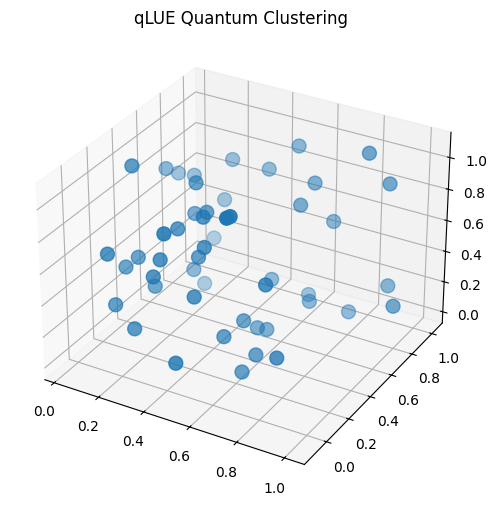

In [34]:
unique_clusters = np.unique(clusters)
cmap = plt.get_cmap("tab10", len(unique_clusters))

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(points[:, 0], points[:, 1], points[:, 2],
                c=clusters, cmap=cmap, s=100)
plt.title("qLUE Quantum Clustering")
# plt.colorbar(sc, ticks=range(len(unique_clusters)))
plt.show()


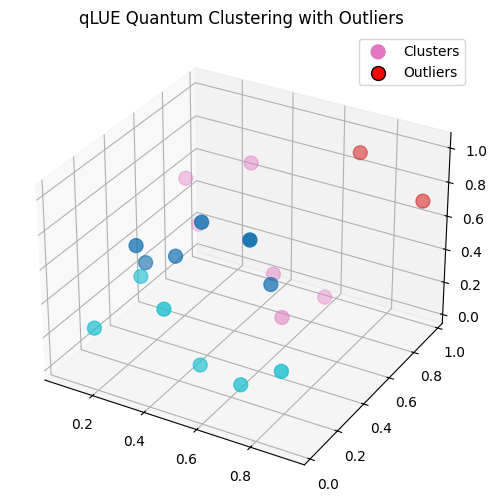

In [240]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Plot inliers (non-outliers) using tab10 colormap
inlier_mask = clusters != -1
inlier_clusters = clusters[inlier_mask]
unique_inlier_clusters = np.unique(inlier_clusters)
cmap = plt.get_cmap("tab10", len(unique_inlier_clusters))

sc = ax.scatter(points[inlier_mask, 0],
                points[inlier_mask, 1],
                points[inlier_mask, 2],
                c=inlier_clusters,
                cmap=cmap,
                s=100,
                label="Clusters")

# Plot outliers in red with black edge
outlier_mask = clusters == -1
ax.scatter(points[outlier_mask, 0],
           points[outlier_mask, 1],
           points[outlier_mask, 2],
           color='red',
           edgecolor='black',
           s=100,
           label="Outliers")

ax.set_title("qLUE Quantum Clustering with Outliers")
ax.legend()
plt.show()


In [218]:
outlier_indices = [i for i, c in enumerate(clusters) if c >= 5]
print("Likely outlier points:", outlier_indices)

Likely outlier points: []


In [219]:
print("Stats:")
for i in range(num_points):
    nj = nearest_higher[i]
    print(f"Point {i:2d}: ρ = {densities[i]:.4f}, dist to Nj = {dist_matrix[i, nj]:.4f}")


Stats:
Point  0: ρ = 0.3984, dist to Nj = 0.0790
Point  1: ρ = 0.3984, dist to Nj = 0.1332
Point  2: ρ = 0.3984, dist to Nj = 0.0000
Point  3: ρ = 0.3984, dist to Nj = 0.0269
Point  4: ρ = 0.3984, dist to Nj = 0.0793
Point  5: ρ = 0.3984, dist to Nj = 0.1236
Point  6: ρ = 0.3984, dist to Nj = 0.0000
Point  7: ρ = 0.3984, dist to Nj = 0.0819
Point  8: ρ = 0.3984, dist to Nj = 0.1159
Point  9: ρ = 0.3984, dist to Nj = 0.0000
Point 10: ρ = 0.3984, dist to Nj = 0.0512
Point 11: ρ = 0.3984, dist to Nj = 0.1149
Point 12: ρ = 0.3984, dist to Nj = 0.1010
Point 13: ρ = 0.3984, dist to Nj = 0.0000
Point 14: ρ = 0.3984, dist to Nj = 0.1663
Point 15: ρ = 0.2539, dist to Nj = 0.0000
Point 16: ρ = 0.2539, dist to Nj = 0.7063
Point 17: ρ = 0.0000, dist to Nj = 0.0000
Point 18: ρ = 0.0000, dist to Nj = 0.0000
Point 19: ρ = 0.2539, dist to Nj = 0.9478


In [221]:
for i in range(15, 20):
    for j in range(i+1, 20):
        print(f"dist({i},{j}) = {np.linalg.norm(points[i] - points[j]):.4f}")

dist(15,16) = 0.7063
dist(15,17) = 3.1871
dist(15,18) = 4.5064
dist(15,19) = 0.9478
dist(16,17) = 2.7355
dist(16,18) = 4.2190
dist(16,19) = 0.9590
dist(17,18) = 2.2857
dist(17,19) = 2.5710
dist(18,19) = 4.1972


In [222]:
marked = distance_oracle(16, dist_matrix, radius=2)
print("Marked neighbors of point 16:", marked)

if marked:
    probs = grover_iterations(marked, num_iter=1)
    for i in range(len(probs)):
        if probs[i] > 1e-4:
            print(f"|{i:05b}⟩: prob = {probs[i]:.4f}")
    print("ρ(16) = ", sum(probs[i] for i in marked))
else:
    print("No marked neighbors — expected ρ = 0")

Marked neighbors of point 16: [15, 19]
|00000⟩: prob = 0.0176
|00001⟩: prob = 0.0176
|00010⟩: prob = 0.0176
|00011⟩: prob = 0.0176
|00100⟩: prob = 0.0176
|00101⟩: prob = 0.0176
|00110⟩: prob = 0.0176
|00111⟩: prob = 0.0176
|01000⟩: prob = 0.0176
|01001⟩: prob = 0.0176
|01010⟩: prob = 0.0176
|01011⟩: prob = 0.0176
|01100⟩: prob = 0.0176
|01101⟩: prob = 0.0176
|01110⟩: prob = 0.0176
|01111⟩: prob = 0.2363
|10000⟩: prob = 0.0176
|10001⟩: prob = 0.0176
|10010⟩: prob = 0.0176
|10011⟩: prob = 0.2363
|10100⟩: prob = 0.0176
|10101⟩: prob = 0.0176
|10110⟩: prob = 0.0176
|10111⟩: prob = 0.0176
|11000⟩: prob = 0.0176
|11001⟩: prob = 0.0176
|11010⟩: prob = 0.0176
|11011⟩: prob = 0.0176
|11100⟩: prob = 0.0176
|11101⟩: prob = 0.0176
|11110⟩: prob = 0.0176
|11111⟩: prob = 0.0176
ρ(16) =  0.47265624999999867


In [223]:
print("Distances from point 16:")
for i in range(num_points):
    if i != 16:
        print(f"dist(16, {i}) = {dist_matrix[16, i]:.4f}")

Distances from point 16:
dist(16, 0) = 29.2365
dist(16, 1) = 24.1386
dist(16, 2) = 17.1314
dist(16, 3) = 24.1963
dist(16, 4) = 17.1829
dist(16, 5) = 17.1970
dist(16, 6) = 17.2224
dist(16, 7) = 29.2843
dist(16, 8) = 24.0497
dist(16, 9) = 24.1905
dist(16, 10) = 29.2491
dist(16, 11) = 24.2437
dist(16, 12) = 29.2012
dist(16, 13) = 29.2354
dist(16, 14) = 17.1115
dist(16, 15) = 0.7063
dist(16, 17) = 2.7355
dist(16, 18) = 4.2190
dist(16, 19) = 0.9590


In [232]:
from sklearn.datasets import make_blobs

# Parameters
num_clusters = 3
points_per_cluster = 5
num_outliers = 5
cluster_std = 0.5  # tight blobs

# 1. Generate clustered data
X_clusters, _ = make_blobs(n_samples=num_clusters * points_per_cluster,
                           centers=num_clusters, n_features=3,
                           cluster_std=cluster_std, random_state=42)

# 2. Generate distant outliers
X_outliers = np.random.uniform(low=10, high=15, size=(num_outliers, 3))

# 3. Combine into one dataset
points = np.vstack([X_clusters, X_outliers])
num_points = len(points)
num_qubits = int(np.ceil(np.log2(num_points)))

# 4. Recalculate distances
dist_matrix = np.linalg.norm(points[:, None, :] - points[None, :, :], axis=2)
